In [28]:
from scipy.optimize import Bounds
import numpy as np
from scipy.optimize import minimize
import joblib
import os

from deap import base
from deap import creator
from deap import tools
import matplotlib.pyplot as plt

import random
from time import time



In [2]:
NUM_CLUSTERS = 7
g = 800

In [3]:
CLUSTER_DIM = 7 * NUM_CLUSTERS

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

toolbox.register("attr_flt", random.uniform, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_flt,n=CLUSTER_DIM)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)

matrix_np = joblib.load('matrix_np.pkl')
matrix_algorithm = matrix_np



# Create Folders

In [4]:
path = "./results/convergence/fobjQuadraticError/iteration{}".format(g)
try:
    if not os.path.isdir(path):
        os.makedirs(path)
except OSError:
    print ("Creation of the directory %s failed" % path)
else:
    print ("Successfully created the directory %s " % path)

Successfully created the directory ./results/convergence/fobjQuadraticError/iteration800 


# Define Functions

In [5]:
def auxiliarFunction(documents, dimensions, number_topics):

    counter_docs = [0 for x in range(0,number_topics)]
    
    distance_to_cluster_2 = [0 for x in range(0,number_topics)] # distances to cluster
    
    for document in documents: 
        distance_to_cluster = []   
        counter = 0
        for dim in range(0,number_topics): 
            distance_to_cluster.append(np.linalg.norm(document-dimensions[counter:counter+7]))
            counter = counter + 7
            
        best_distance_index = distance_to_cluster.index(min(distance_to_cluster)) 
        
        counter_docs[best_distance_index] += 1
    
        distance_to_cluster_2[best_distance_index] += pow(distance_to_cluster[best_distance_index], 2)
        
     
    return counter_docs, distance_to_cluster_2

In [6]:
def fobjInertia(k):
    
    num_topics = int((len(k))/7)
    
    # 1º Number of documents to each cluster
    counter_documents, euclidean_dist_2 = auxiliarFunction(documents = matrix_algorithm, dimensions= k, number_topics = num_topics)
    
    bool_check = 0 in counter_documents    

   # 2º Fitness fuction
    if(bool_check):
        total_value = 1000000000 # We give a high value to those clusters who do not have documents
        
    else:
        total_value = sum(euclidean_dist_2) 
    return total_value

In [7]:
def fobjQuadraticError(k):

    num_topics = int((len(k))/7)
    
    # 1º Number of documents to each cluster
    counter_documents, euclidean_dist_2 = auxiliarFunction(documents = matrix_algorithm, dimensions= k, number_topics = num_topics)
    
    bool_check = 0 in counter_documents    

   # 2º Fitness fuction
    if(bool_check):
        total_value = 5 # We give a high value to those clusters who do not have documents
        
    else:
        value1 = 0
        for i in range(0,num_topics): 
            value2 = euclidean_dist_2[i] 
            value1 += ((1/counter_documents[i])*value2)

        total_value = (value1 / num_topics) 

    return (total_value)

# Manual Steepest Descent

In [ ]:
def steepestDescentMethod(initial_sol, fobj, num_clust, num_iterations, step_derivate, stop_crit):
    num_var = 7 * num_clust
    if (num_var != len(initial_sol)):
        print("Numero de K incorrecta")
        return None
    
    current_sol = initial_sol 
    current_val = fobj(current_sol) 
    
    for it in range(0, num_iterations):
        print(it)
        # Gradient
        grad = [0 for _ in range(0,num_var)] 
        
        for i in range(0, num_var): 
            current_sol_plus = current_sol
            current_sol_plus[i] = current_sol_plus[i] + step_derivate # (x + h)
            grad[i] = (fobj(current_sol_plus) - current_val)/step_derivate # f' = (f(x+h) - f(x))/h => Para cada una de las dimensiones
    
        t0 = 0 # En la ecuacion parametrica => evaluamos inicialmente g(t=0) = f(x0)
               
        grad = np.array(grad)
        for it2 in range (0, num_iterations): # Hacemos Newton para buscar punto óptimo
            obj0 = fobj(current_sol - t0*grad) # g(t) que es a su vez f(x)=f(x0-t0*gradf)
            objp = fobj(current_sol-(t0+step_derivate)*grad) # f(x+h)
            objm = fobj(current_sol-(t0-step_derivate)*grad) #f(x-h)
            
            # t+1 = t - (f'(t)/f''(t)) => Newton
            t1 = t0 - ((objp-obj0)/step_derivate) / ((objp-2*obj0+objm)/(pow(step_derivate,2)))
            obj_fin = fobj(current_sol-t1*grad) 
            t0 = t1
            
            if (abs(obj_fin-obj0)<stop_crit): 
                break
                
        new_sol = current_sol-t1*grad #Nueva x conjunto de clusteres más optimos
        new_value = obj_fin # fobj(x)
        
        if (abs(new_value - current_val)<stop_crit):
            break
        else:
            current_sol = new_sol
            current_val = new_value
            print(current_val)
            
    solution = new_sol
    value = new_value
    
    return solution, value

In [ ]:
solution, value = steepestDescentMethod(ind_iterations[-1], fobj= fobjQuadraticError, num_clust= num_topics, num_iterations=1000, step_derivate=0.00001, stop_crit=0.000001)

# Linear restrictions

Linear restriction for each cluster => Simplex

In [9]:
def sum_one1 (k):
    sum  = 0
    for i in range(7):
        sum = sum + k[0*7+i]
    sum = abs(sum-1)
    return sum
    

In [10]:
def sum_one2 (k):
    sum  = 0
    for i in range(7):
        sum = sum + k[1*7+i]
    sum = abs(sum-1)
    return sum

In [11]:
def sum_one3 (k):
    sum  = 0
    for i in range(7):
        sum = sum + k[2*7+i]
    sum = abs(sum-1)
    return sum

In [12]:
def sum_one4 (k):
    sum  = 0
    for i in range(7):
        sum = sum + k[3*7+i]
    sum = abs(sum-1)
    return sum

In [13]:
def sum_one5 (k):
    sum  = 0
    for i in range(7):
        sum = sum + k[4*7+i]
    sum = abs(sum-1)
    return sum

In [14]:
def sum_one6 (k):
    sum  = 0
    for i in range(7):
        sum = sum + k[5*7+i]
    sum = abs(sum-1)
    return sum

In [15]:
def sum_one7 (k):
    sum  = 0
    for i in range(7):
        sum = sum + k[6*7+i]
    sum = abs(sum-1)
    return sum

Cluster-Centroids coordinates from best GA (fobj => 0.085)

In [16]:
best_ind_qua = [0.08677035865210417, 0.07278468712428088, 0.07109726182607509, 0.4904948137060272, 0.09094998615804475, 0.0989125036064867, 0.08899038892698147, 0.5270465950617436, 0.07692425033026434, 0.07298998649076999, 0.08838148821350596, 0.0782574396572057, 0.045150883561909466, 0.11124935668460073, 0.06956840289940822, 0.06410684430351289, 0.0620043574482015, 0.06593183540050367, 0.08777158651469993, 0.06235934461899528, 0.5882576288146786, 0.07427020259065427, 0.4895285705813661, 0.09548090971259429, 0.06934601238291002, 0.0884145995843863, 0.08787019194165241, 0.09508951320643658, 0.06802896944417813, 0.10270313010011142, 0.10596313348643696, 0.08170172003230411, 0.07840352583234647, 0.4930168144094431, 0.07018270669517965, 0.09125486275914127, 0.08737765255740326, 0.07529169583310306, 0.0799640209212711, 0.512692538835611, 0.06211787976351038, 0.0913013493299602, 0.08847800619080015, 0.08981823273928771, 0.49349383502511723, 0.054521657611092095, 0.08764783879936638, 0.10199709557651074, 0.08404333405782603]

In [17]:
cons1 = {'type': 'eq', 'fun': sum_one1}
cons2 = {'type': 'eq', 'fun': sum_one2}
cons3 = {'type': 'eq', 'fun': sum_one3}
cons4 = {'type': 'eq', 'fun': sum_one4}
cons5 = {'type': 'eq', 'fun': sum_one5}
cons6 = {'type': 'eq', 'fun': sum_one6}
cons7 = {'type': 'eq', 'fun': sum_one7}

cons = [cons1,cons2,cons3,cons4,cons5,cons6,cons7]

In [18]:
def callbackF(Xi):
    global Nfeval
    print ('{0:4d} {1: 3.6f}'.format(Nfeval, fobjQuadraticError(Xi)))
    Nfeval += 1

# Local Convergence Algorithm

## SLSQP

In [19]:
start_time = time()

Nfeval = 1

print  ('{0:4s}  {1:9s}'.format('Iter', 'f(X)'))

res = minimize(fun = fobjQuadraticError, x0= best_ind_qua, args=(), method='SLSQP', jac=None, 
               bounds=bounds, constraints=cons, tol=None, callback=callbackF,
               options={'maxiter': 100, 'ftol': 0.0000001, 'iprint': 1, 'disp': True, 
               'eps': 0.0000001, 'finite_diff_rel_step': None})
print(res.x)

print("--- {} s seconds ---".format((time() - start_time)))

joblib.dump(res.x, "results/convergence/fobjQuadraticError/iteration{}/SLSQP.pkl".format(g))

Iter  f(X)     
   1  0.084250
   2  0.105616
   3  0.082737
   4  0.082711
   5  0.082693
   6  0.082683
   7  0.082675
   8  0.082662
   9  0.082643
  10  0.082630
  11  0.082625
  12  0.082625
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.08262480360461126
            Iterations: 12
            Function evaluations: 603
            Gradient evaluations: 12
[0.07090695 0.05472499 0.04853281 0.57385279 0.08962707 0.08657469
 0.07578069 0.59317938 0.06076465 0.05862975 0.07064416 0.06814184
 0.04867284 0.09996735 0.06900363 0.05984088 0.053046   0.0576334
 0.07372197 0.05189116 0.63486295 0.07800525 0.50455501 0.08606383
 0.0680363  0.09070192 0.08341853 0.08921917 0.060258   0.08105422
 0.09413673 0.09088451 0.07929615 0.52263475 0.07173562 0.07688051
 0.06956704 0.06030905 0.07134867 0.57871554 0.0567995  0.08637969
 0.08485652 0.07823738 0.53178314 0.05498048 0.08116257 0.09027348
 0.07870644]
--- 4515.074224472046 s seconds ---


['results/convergence/fobjQuadraticError/iteration800/SLSQP.pkl']

# Best result (Hybridized GA)

In [26]:
print(fobjQuadraticError([0.07090695, 0.05472499, 0.04853281, 0.57385279, 0.08962707,
       0.08657469, 0.07578069, 0.59317938, 0.06076465, 0.05862975,
       0.07064416, 0.06814184, 0.04867284, 0.09996735, 0.06900363,
       0.05984088, 0.053046  , 0.0576334 , 0.07372197, 0.05189116,
       0.63486295, 0.07800525, 0.50455501, 0.08606383, 0.0680363 ,
       0.09070192, 0.08341853, 0.08921917, 0.060258  , 0.08105422,
       0.09413673, 0.09088451, 0.07929615, 0.52263475, 0.07173562,
       0.07688051, 0.06956704, 0.06030905, 0.07134867, 0.57871554,
       0.0567995 , 0.08637969, 0.08485652, 0.07823738, 0.53178314,
       0.05498048, 0.08116257, 0.09027348, 0.07870644]))

0.08262480360994985


# Plot results

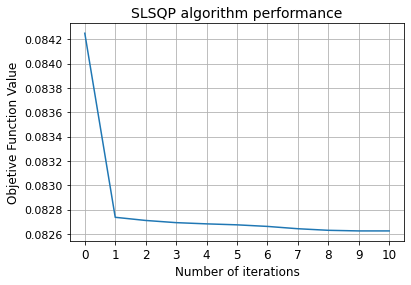

In [68]:
convergence_values = [0.084250 ,0.082737, 0.082711, 0.082693, 0.082683, 0.082675, 0.082662, 0.082643, 0.082630, 0.082625, 0.082625]
plt.plot(convergence_values)
plt.xticks(np.arange(0,11, step=1), fontsize = 12)
plt.yticks(fontsize = 11)
plt.xlabel('Number of iterations', fontsize = 12)
plt.ylabel('Objetive Function Value', fontsize = 12)
plt.title('SLSQP algorithm performance', fontsize = 14 )
plt.grid()
plt.show()